In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the GPT-2 and Roberta embeddings (as floats)
gpt2 = np.load('gpt2.npy').astype(float)
roberta = np.load('Roberta.npy').astype(float)

In [3]:
# Verify the shape of these arrays
print(f"GPT-2 shape: {gpt2.shape}")
print(f"RoBERTa shape: {roberta.shape}")

GPT-2 shape: (4734, 1600)
RoBERTa shape: (4734, 1024)


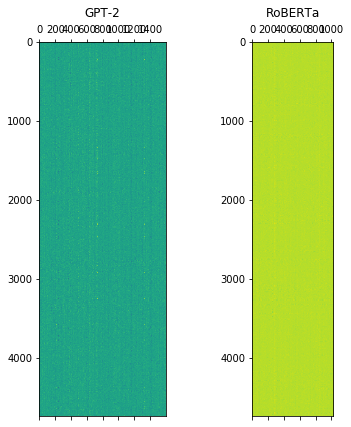

In [4]:
# Visualize these arrays
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(6, 6))
axs[0].matshow(gpt2)
axs[0].set_title('GPT-2')
axs[1].matshow(roberta)
axs[1].set_title('RoBERTa')
plt.tight_layout()

In [5]:
# Scales look pretty different so let's z-score features
from scipy.stats import zscore
gpt2 = zscore(gpt2, axis=0)
roberta = zscore(roberta, axis=0)

In [6]:
# First we'll try simple orthogonal Procrustes
from scipy.linalg import orthogonal_procrustes

In [7]:
# Function to horizontal-pad zeros on a smaller array
def hpad_zeros(a, target_dim):
    assert a.shape[1] < target_dim
    zeros = np.zeros((a.shape[0],
                      target_dim - a.shape[1]))
    padded = np.hstack((a, zeros))
    return padded   

In [8]:
# Pad zeros onto RoBERTa dataset to match GPT-2
roberta_pad = hpad_zeros(roberta, gpt2.shape[1])

In [9]:
# Get the othorgonal Procrustes matrix
ort, sv = orthogonal_procrustes(gpt2, roberta_pad)

In [10]:
# Align GPT-2 to RoBERTa
gpt2_procrustes = gpt2.dot(ort)

In [11]:
# Compute within-model representational geometry before/after
from scipy.spatial.distance import pdist, squareform
gpt2_original_rdm = squareform(pdist(gpt2, metric='cosine'))
gpt2_procrustes_rdm = squareform(pdist(gpt2_procrustes, metric='cosine'))
roberta_rdm = squareform(pdist(roberta, metric='cosine'))

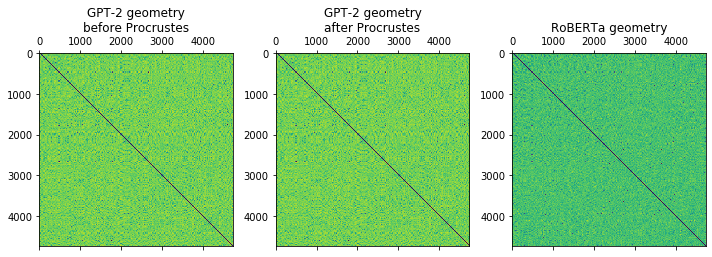

In [12]:
# Visualize representational before and after Procrustes
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(10, 4))
axs[0].matshow(gpt2_original_rdm)
axs[0].set_title('GPT-2 geometry\nbefore Procrustes',
                 y=1.08)
axs[1].matshow(gpt2_procrustes_rdm)
axs[1].set_title('GPT-2 geometry\nafter Procrustes',
                 y=1.08)
axs[2].matshow(roberta_rdm)
axs[2].set_title('RoBERTa geometry',
                 y=1.08)
plt.tight_layout()

In [14]:
# Compute sample-wise distances between datasets
from scipy.spatial.distance import cdist
original_dist = cdist(gpt2, roberta_pad, metric='cosine')
procrustes_dist = cdist(gpt2_procrustes, roberta_pad, metric='cosine')

In [15]:
# Get sample-wise cosine similarities
print(f"Cosine similarity before: {1 - np.mean(original_dist.diagonal())}")
print(f"Cosine similarity after: {1 - np.mean(procrustes_dist.diagonal())}")

Cosine similarity before: 0.00043525052574167056
Cosine similarity after: 0.5606790232019736


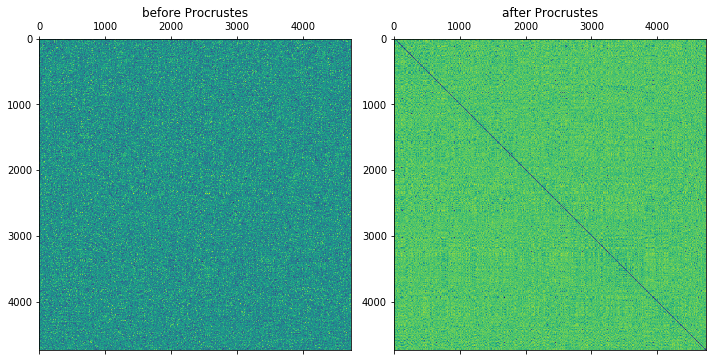

In [16]:
# Visualize sample-wise alignment before and after
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))
axs[0].matshow(original_dist)
axs[0].set_title('before Procrustes')
axs[1].matshow(procrustes_dist)
axs[1].set_title('after Procrustes')
plt.tight_layout()

In [17]:
# Now let's try SRM
from brainiak.funcalign.srm import SRM

In [18]:
# Fit SRM with arbitrary 100 features
n_features = 100
srm = SRM(n_iter=10, features=n_features)
srm.fit([gpt2.T, roberta.T])

SRM(comm=<mpi4py.MPI.Intracomm object at 0x118babdf0>, features=100, n_iter=10,
    rand_seed=0)

In [19]:
# Transform the data into shared space using SRM transformations
gpt2_srm = gpt2.dot(srm.w_[0])
roberta_srm = roberta.dot(srm.w_[1])

In [20]:
# Compute within-model representational geometry before/after
from scipy.spatial.distance import pdist, squareform
gpt2_srm_rdm = squareform(pdist(gpt2_srm, metric='cosine'))
roberta_srm_rdm = squareform(pdist(roberta_srm, metric='cosine'))

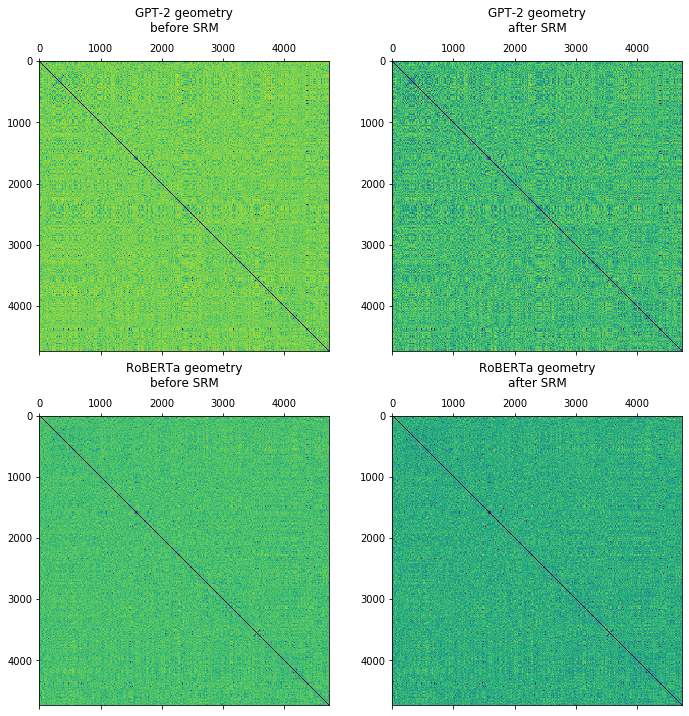

In [21]:
# Visualize representational geometry before and after SRM
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
axs[0][0].matshow(gpt2_original_rdm)
axs[0][0].set_title('GPT-2 geometry\nbefore SRM',
                 y=1.08)
axs[0][1].matshow(gpt2_srm_rdm)
axs[0][1].set_title('GPT-2 geometry\nafter SRM',
                 y=1.08)
axs[1][0].matshow(roberta_rdm)
axs[1][0].set_title('RoBERTa geometry\nbefore SRM',
                 y=1.08)
axs[1][1].matshow(roberta_srm_rdm)
axs[1][1].set_title('RoBERTa geometry\nafter SRM',
                 y=1.08)
plt.tight_layout()

In [22]:
# Compute sample-wise distances between datasets
from scipy.spatial.distance import cdist
srm_dist = cdist(gpt2_srm, roberta_srm, metric='cosine')

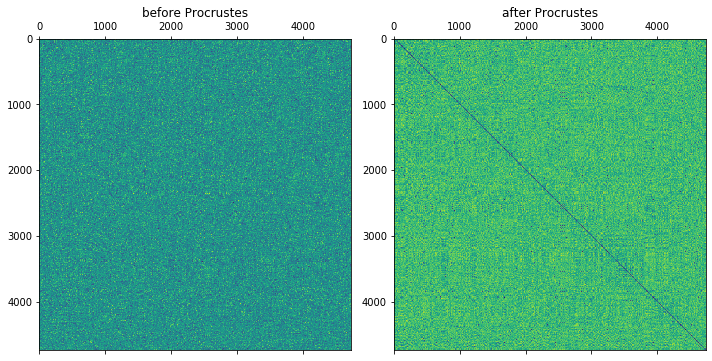

In [23]:
# Visualize sample-wise alignment before and after
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))
axs[0].matshow(original_dist)
axs[0].set_title('before Procrustes')
axs[1].matshow(srm_dist)
axs[1].set_title('after Procrustes')
plt.tight_layout()

In [24]:
# Get sample-wise cosine similarities
print(f"Cosine similarity before: {1 - np.mean(original_dist.diagonal())}")
print(f"Cosine similarity after: {1 - np.mean(srm_dist.diagonal())}")

Cosine similarity before: 0.00043525052574167056
Cosine similarity after: 0.5964059143782843
